In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor,XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [22]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\n컬럼 목록: {train_df.columns.tolist()}")

Train shape: (630000, 15)
Test shape: (270000, 14)

컬럼 목록: ['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease']


In [23]:
train_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Heart Disease  

In [24]:
for col in train_df.columns:
    cols = train_df[col].unique()
    if len(cols)<10:
        print(f'{col} : {cols}')

Sex : [1 0]
Chest pain type : [4 1 2 3]
FBS over 120 : [0 1]
EKG results : [0 2 1]
Exercise angina : [1 0]
Slope of ST : [2 1 3]
Number of vessels fluro : [2 0 3 1]
Thallium : [7 3 6]
Heart Disease : <StringArray>
['Presence', 'Absence']
Length: 2, dtype: str


#### 1. EDA 코드
- 각 범주별 데이터 갯수
- 각 범주별 심장병 비율

In [25]:
def plot_features_dual_axis(
    df: pd.DataFrame,
    cols: list[str],
    target_col: str,
    n_bins: int = 10,
    n_wide: int = 3,
    figsize_per_plot: tuple[float, float] = (5, 4),
    int_as_cat_unique_max: int | None = 20,
    cat_order: dict[str, list] | None = None,
):
    BAR_COLOR = "tab:blue"
    LINE_COLOR = "tab:orange"
    BASELINE_COLOR = "red"

    def is_categorical(s: pd.Series) -> bool:
        return s.dtype == "object" or pd.api.types.is_string_dtype(s)

    # ===== 타겟이 이진 분류인지 확인 =====
    target_unique = df[target_col].dropna().unique()
    is_binary_target = (
        len(target_unique) == 2 
        and set(target_unique).issubset({0, 1, 0.0, 1.0})
    )
    
    if is_binary_target:
        # 전체 데이터의 positive rate (baseline)
        overall_positive_rate = df[target_col].mean()
        y_label = f"{target_col} = 1 Rate"
        y_format = "percentage"  # 0~100% 표시
    else:
        overall_positive_rate = None
        y_label = f"Mean {target_col}"
        y_format = "raw"

    n_cols = len(cols)
    n_rows = int(np.ceil(n_cols / n_wide))

    fig, axes = plt.subplots(
        n_rows,
        n_wide,
        figsize=(figsize_per_plot[0] * n_wide, figsize_per_plot[1] * n_rows),
    )

    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols):
        ax1 = axes[i]
        col_safe = col.replace("_", r"\_")

        n_nan = df[col].isna().sum()
        n_unique = df[col].nunique(dropna=True)

        tmp = df[[col, target_col]].dropna()
        if tmp.empty:
            ax1.set_title(
                rf"$\bf{{{col_safe}}}$"
                f"\n(empty after dropna; {n_unique} unique, {n_nan} nan)"
            )
            continue

        x = tmp[col]
        y = tmp[target_col]

        # ---------- TRUE CATEGORICAL ----------
        if is_categorical(x):
            type_str = "categorical"

            counts = x.value_counts()
            mean_y = tmp.groupby(col)[target_col].mean()

            if cat_order is not None and col in cat_order:
                desired = list(cat_order[col])
                ordered = [c for c in desired if c in counts.index]
                remaining = [c for c in counts.index if c not in ordered]
                final_order = ordered + remaining
            else:
                final_order = sorted(counts.index)

            counts = counts.loc[final_order]
            mean_y = mean_y.loc[final_order]

            xpos = np.arange(len(final_order))

            # Bar plot
            ax1.bar(xpos, counts.values, alpha=0.6, color=BAR_COLOR)
            ax1.set_xlabel(col)
            ax1.set_ylabel("Count", color=BAR_COLOR)
            ax1.tick_params(axis="y", colors=BAR_COLOR)

            ax1.set_xticks(xpos)
            ax1.set_xticklabels(final_order, rotation=45, ha="right")

            # Line plot
            ax2 = ax1.twinx()
            
            if y_format == "percentage":
                mean_y_display = mean_y.values * 100
                ax2.set_ylim(0, 105)  # 0~100% + 여유
                
                # Baseline 추가
                ax2.axhline(
                    overall_positive_rate * 100, 
                    color=BASELINE_COLOR, 
                    linestyle='--', 
                    linewidth=1.5,
                    alpha=0.7,
                    label=f'Overall: {overall_positive_rate*100:.1f}%'
                )
                ax2.legend(loc='upper right', fontsize=8)
            else:
                mean_y_display = mean_y.values
            
            ax2.plot(xpos, mean_y_display, marker="o", color=LINE_COLOR, linewidth=2)
            ax2.set_ylabel(y_label, color=LINE_COLOR)
            ax2.tick_params(axis="y", colors=LINE_COLOR)

            ax1.set_title(
                rf"$\bf{{{col_safe}}}$: Count vs {y_label}"
                f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
            )

        # ---------- NUMERIC ----------
        else:
            type_str = "numeric"

            xvals = x.values
            yvals = y.values

            mask = np.isfinite(xvals) & np.isfinite(yvals)
            xvals = xvals[mask]
            yvals = yvals[mask]

            if len(xvals) == 0:
                ax1.set_title(
                    rf"$\bf{{{col_safe}}}$"
                    f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
                )
                continue

            unique_vals = np.sort(np.unique(xvals))
            n_unique_eff = len(unique_vals)

            # --- Case 1: int-as-categorical ---
            if int_as_cat_unique_max is not None and n_unique_eff <= int_as_cat_unique_max:
                counts = np.array([(xvals == v).sum() for v in unique_vals])
                mean_y = np.array([yvals[xvals == v].mean() for v in unique_vals])

                xpos = np.arange(n_unique_eff)

                ax1.bar(xpos, counts, alpha=0.6, color=BAR_COLOR)
                ax1.set_xlabel(col)
                ax1.set_ylabel("Count", color=BAR_COLOR)
                ax1.tick_params(axis="y", colors=BAR_COLOR)

                rotate = 45 if n_unique_eff > n_bins else 0
                step = max(int(np.ceil(n_unique_eff / n_bins)), 1)
                tick_idx = np.arange(0, n_unique_eff, step)

                if pd.api.types.is_integer_dtype(x):
                    tick_labels = unique_vals[tick_idx].astype(int)
                else:
                    tick_labels = unique_vals[tick_idx]

                ax1.set_xticks(tick_idx)
                ax1.set_xticklabels(
                    tick_labels,
                    rotation=rotate,
                    ha="right" if rotate else "center",
                )

                ax2 = ax1.twinx()
                
                if y_format == "percentage":
                    mean_y_display = mean_y * 100
                    ax2.set_ylim(0, 105)
                    ax2.axhline(
                        overall_positive_rate * 100, 
                        color=BASELINE_COLOR, 
                        linestyle='--', 
                        linewidth=1.5,
                        alpha=0.7,
                        label=f'Overall: {overall_positive_rate*100:.1f}%'
                    )
                    ax2.legend(loc='upper right', fontsize=8)
                else:
                    mean_y_display = mean_y
                
                ax2.plot(xpos, mean_y_display, marker="o", color=LINE_COLOR, linewidth=2)
                ax2.set_ylabel(y_label, color=LINE_COLOR)
                ax2.tick_params(axis="y", colors=LINE_COLOR)

                ax1.set_title(
                    rf"$\bf{{{col_safe}}}$: Per-Value Count vs {y_label}"
                    f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
                )

            # --- Case 2: low-cardinality numeric bins ---
            elif n_unique_eff < n_bins:
                counts = np.array([(xvals == v).sum() for v in unique_vals])
                mean_y = np.array([yvals[xvals == v].mean() for v in unique_vals])

                width = 0.8 * (np.min(np.diff(unique_vals)) if n_unique_eff > 1 else 1.0)

                ax1.bar(unique_vals, counts, width=width, alpha=0.6, color=BAR_COLOR)
                ax1.set_xlabel(col)
                ax1.set_ylabel("Count", color=BAR_COLOR)
                ax1.tick_params(axis="y", colors=BAR_COLOR)

                ax2 = ax1.twinx()
                
                if y_format == "percentage":
                    mean_y_display = mean_y * 100
                    ax2.set_ylim(0, 105)
                    ax2.axhline(
                        overall_positive_rate * 100, 
                        color=BASELINE_COLOR, 
                        linestyle='--', 
                        linewidth=1.5,
                        alpha=0.7,
                        label=f'Overall: {overall_positive_rate*100:.1f}%'
                    )
                    ax2.legend(loc='upper right', fontsize=8)
                else:
                    mean_y_display = mean_y
                
                ax2.plot(unique_vals, mean_y_display, marker="o", color=LINE_COLOR, linewidth=2)
                ax2.set_ylabel(y_label, color=LINE_COLOR)
                ax2.tick_params(axis="y", colors=LINE_COLOR)

                ax1.set_title(
                    rf"$\bf{{{col_safe}}}$: Per-Value Count vs {y_label}"
                    f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
                )

            # --- Case 3: regular histogram ---
            else:
                bins = np.linspace(xvals.min(), xvals.max(), n_bins + 1)
                bin_centers = 0.5 * (bins[:-1] + bins[1:])

                counts, _ = np.histogram(xvals, bins=bins)
                bin_idx = np.digitize(xvals, bins) - 1

                mean_y = np.array([
                    yvals[bin_idx == j].mean() if np.any(bin_idx == j) else np.nan
                    for j in range(n_bins)
                ])

                ax1.bar(
                    bin_centers,
                    counts,
                    width=(bins[1] - bins[0]),
                    alpha=0.6,
                    color=BAR_COLOR,
                )
                ax1.set_xlabel(col)
                ax1.set_ylabel("Count", color=BAR_COLOR)
                ax1.tick_params(axis="y", colors=BAR_COLOR)

                ax2 = ax1.twinx()
                
                if y_format == "percentage":
                    mean_y_display = mean_y * 100
                    ax2.set_ylim(0, 105)
                    ax2.axhline(
                        overall_positive_rate * 100, 
                        color=BASELINE_COLOR, 
                        linestyle='--', 
                        linewidth=1.5,
                        alpha=0.7,
                        label=f'Overall: {overall_positive_rate*100:.1f}%'
                    )
                    ax2.legend(loc='upper right', fontsize=8)
                else:
                    mean_y_display = mean_y
                
                ax2.plot(bin_centers, mean_y_display, marker="o", color=LINE_COLOR, linewidth=2)
                ax2.set_ylabel(y_label, color=LINE_COLOR)
                ax2.tick_params(axis="y", colors=LINE_COLOR)

                ax1.set_title(
                    rf"$\bf{{{col_safe}}}$: Histogram vs {y_label}"
                    f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
                )

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [26]:
# 실행전 지정해줄 변수
FEATURES = list( train_df.columns[1:-1] )
print(f"There are {len(FEATURES)} features:")
print(FEATURES)

There are 13 features:
['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']


In [29]:
# replace를 사용해 직접 변경
train_df['Heart Disease'] = train_df['Heart Disease'].replace({'Presence': 1, 'Absence': 0})

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

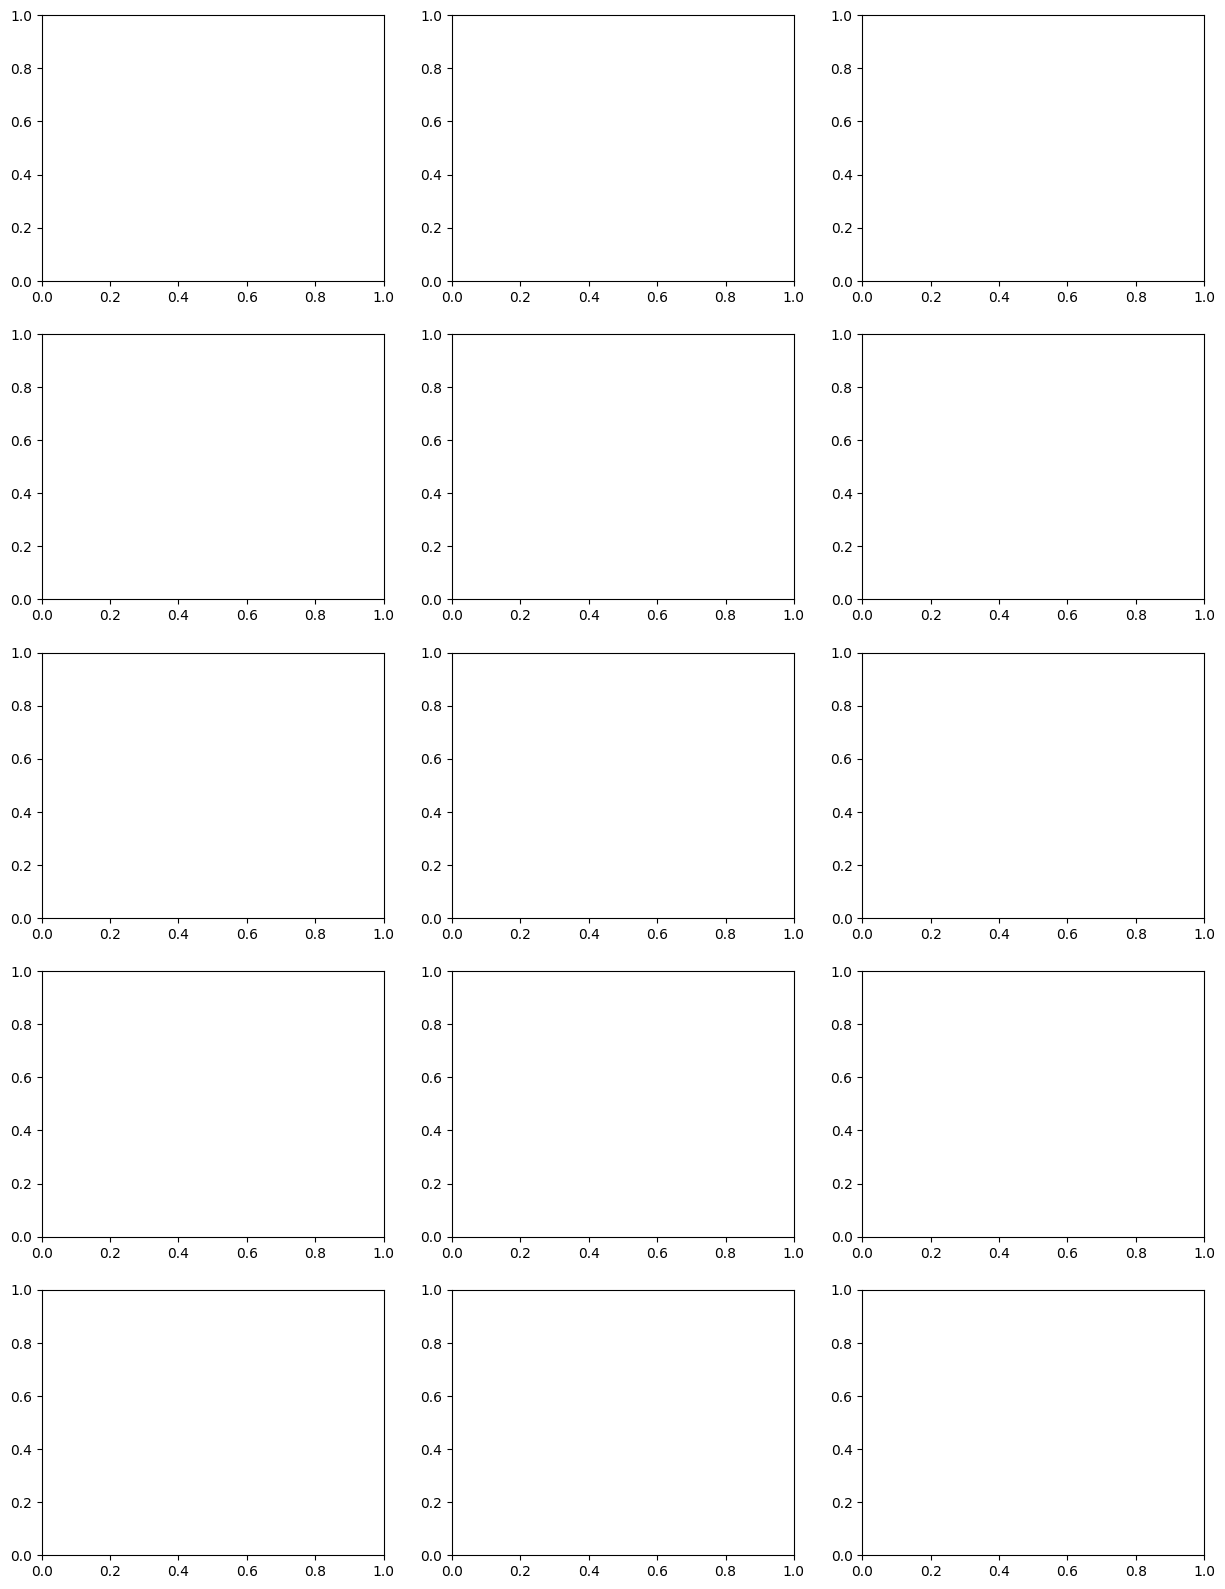

In [30]:
plot_features_dual_axis(
    train_df,
    target_col='Heart Disease',
    cols=FEATURES,
    n_bins=10,
    n_wide=3,
    int_as_cat_unique_max=20
)

#### Age 변수 피처엔지니어링

#### Age
- 선형관계처럼 보이지만, 
- 40~60대에 가파르게 상승, 40대이전은 거의 비슷, 60대이상은 완만하게 상승

##### 피처 엔지니어링 전략
1. 급등 구간표시 
    - age가 40~60인경우를 1로 나머지를 0으로 해서, 40~60의 급등을 모델이 트리를 낭비하지 않고, 쉽게 분할할 도구제공
    - age_40_60구간을 어떻게 정하는가? 

2. 제곱항 추가
    - 왜 age_squared가 가속을 표현할수 있는가? 
        - 나이별 심장병률 증가폭이 다를때 그 변화율을 표현할수있음. 




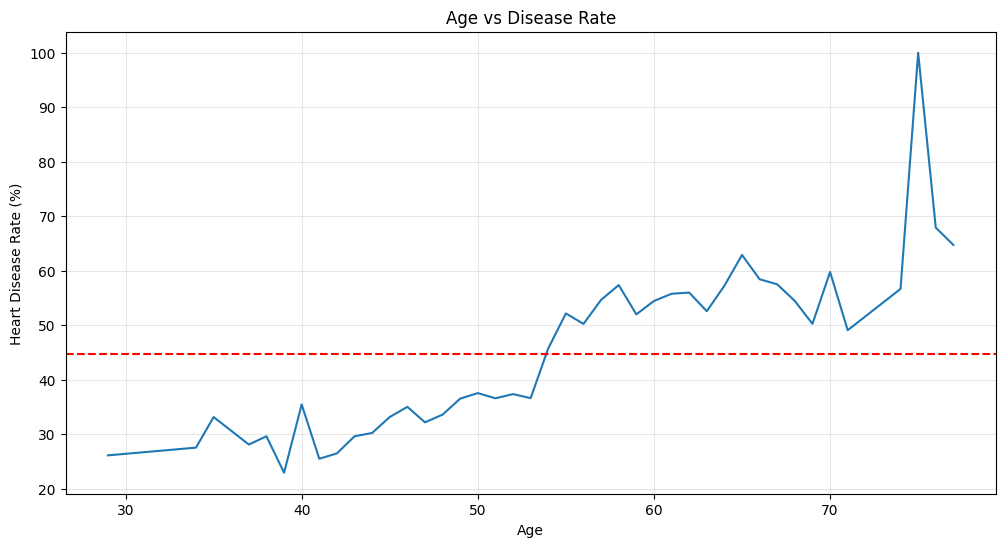

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 나이별 심장병률 계산
age_disease = train_df.groupby('Age')['Heart Disease'].agg(['mean', 'count'])

# 플롯
plt.figure(figsize=(12, 6))
plt.plot(age_disease.index, age_disease['mean'] * 100)
plt.axhline(y=44.8, color='r', linestyle='--', label='Overall')
plt.xlabel('Age')
plt.ylabel('Heart Disease Rate (%)')
plt.title('Age vs Disease Rate')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 증가율 계산
age_disease['rate_change'] = age_disease['mean'].diff()

# 증가율이 큰 구간 찾기
print(age_disease.nlargest(5, 'rate_change'))

         mean  count  rate_change
Age                              
75   1.000000      1     0.433198
40   0.354853   4554     0.125250
70   0.597815   5950     0.095077
54   0.457716  46826     0.091311
74   0.566802    741     0.075801


In [ ]:
from scipy import stats

# 40-60 vs 나머지 구간 비교
group_4060 = train_df[(train_df['Age'] >= 40) & (train_df['Age'] <= 60)]['Heart Disease']
group_others = train_df[(train_df['Age'] < 40) | (train_df['Age'] > 60)]['Heart Disease']

# t-test
t_stat, p_value = stats.ttest_ind(group_4060, group_others)
print(f"p-value: {p_value}")  # p < 0.05면 유의미한 차이

p-value: 0.0


- 만약 비선형성이 착각이였다면? -> 모델이 알아서 무시함 -> 추후 지울지말지, 합성피처로 쓸지 결정하기

#### Chsetpaintype 피처 엔지니어링

#### Chsetpaintype
- 패턴 1,2,3에서는 완만한 상승, 패턴 4에서 급증
- 타입 4 : 무증상
    - 왜 무증상일때 심장병이 더 많은지 -> 다른 비즈니스에서 필요

In [ ]:
# 케이스 1: 원본만
X1 = train_df[['Chest pain type']]
model1 = XGBClassifier(n_estimators=10, max_depth=2)
model1.fit(X1, train_df['Heart Disease'])

print("=== Tree 0 (원본만) ===")
print(model1.get_booster().get_dump()[0])

# 출력:
# 0:[Chestpaintype<3.5] yes=1,no=2
#   1:leaf=0.15
#   2:leaf=0.70
# → 1번에 해결!

=== Tree 0 (원본만) ===
0:[Chest pain type<4] yes=1,no=2,missing=2
	1:[Chest pain type<2] yes=3,no=4,missing=4
		3:leaf=-0.412672013
		4:leaf=-0.322052747
	2:leaf=0.30218786



- 첫 분할에서 4와 나머지로 분리
- 두번째 분할에서 1,2,3 세부적인 내용 분리

In [ ]:
# 케이스 2: chest_type4 추가
train_df['chest_type4'] = (train_df['Chest pain type'] == 4).astype(int)
X2 = train_df[['Chest pain type', 'chest_type4']]
model2 = XGBClassifier(n_estimators=10, max_depth=2)
model2.fit(X2, train_df['Heart Disease'])

print("Feature Importance:")
print(model2.feature_importances_)
# 출력:
# Chestpaintype: 0.55
# chest_type4: 0.45

Feature Importance:
[1. 0.]


- 범주형 변수는 굳이 4가 위험하다고 표시안해줘도 4와 나머지로 나누기때문에 무의미함

#### BP 피처 엔지니어링

- 고혈압일수록 심장병 비율이 높아야 하는데 낮음
1. 혈압 180 환자 -> 이미 고혈압 진단을 받고 심장관리중
2. 혈압 200+ 인 환자는 이미 사망. 180인데도 심장병에 안걸리는 튼튼한 사람만 남았을수도.

In [ ]:
import pandas as pd
import numpy as np

# 타겟 컬럼명
target_col = 'Heart Disease'  # 실제 컬럼명으로 수정!

print("=== 나이대별 혈압-심장병률 분석 ===\n")

for age_group in [(30, 50), (50, 60), (60, 100)]:
    # 해당 나이대 필터링
    subset = train_df[
        (train_df['Age'] >= age_group[0]) &
        (train_df['Age'] < age_group[1])
    ].copy()
    
    print(f"나이대: {age_group[0]}-{age_group[1]}세")
    print(f"데이터 수: {len(subset)}명")
    
    # 혈압 구간별 심장병률
    subset['bp_bin'] = pd.cut(
        subset['BP'], 
        bins=[0, 120, 140, 160, 200],
        labels=['<120', '120-140', '140-160', '160+']
    )
    
    bp_disease = subset.groupby('bp_bin')[target_col].agg(['mean', 'count'])
    bp_disease.columns = ['심장병률', '인원수']
    bp_disease['심장병률'] = (bp_disease['심장병률'] * 100).round(1)
    
    print(bp_disease)
    print()

=== 나이대별 혈압-심장병률 분석 ===

나이대: 30-50세
데이터 수: 173106명
         심장병률    인원수
bp_bin              
<120     30.5  60128
120-140  30.7  84958
140-160  29.9  24711
160+     24.8   3309

나이대: 50-60세
데이터 수: 285688명
         심장병률     인원수
bp_bin               
<120     46.7  100145
120-140  46.9  140062
140-160  46.9   40233
160+     40.0    5248

나이대: 60-100세
데이터 수: 170158명
         심장병률    인원수
bp_bin              
<120     56.6  59454
120-140  56.9  83963
140-160  56.0  23708
160+     50.0   3033



In [ ]:
# 단순 혈압별 심장병률
bp_bins = pd.cut(train_df['BP'], bins=[0, 100, 120, 140, 160, 180, 200])
bp_disease_overall = train_df.groupby(bp_bins)[target_col].agg(['mean', 'count'])
bp_disease_overall.columns = ['심장병률', '인원수']
bp_disease_overall['심장병률'] = (bp_disease_overall['심장병률'] * 100).round(1)

print("=== 전체 혈압별 심장병률 ===")
print(bp_disease_overall)

=== 전체 혈압별 심장병률 ===
            심장병률     인원수
BP                      
(0, 100]    43.9    7630
(100, 120]  44.9  212491
(120, 140]  45.1  309472
(140, 160]  44.6   88796
(160, 180]  38.1   10349
(180, 200]  39.1    1262


In [ ]:
from scipy import stats

# 젊은 사람 vs 노인의 혈압-심장병 관계 비교

# 젊은 사람 (30-50세)
young = train_df[(train_df['Age'] >= 30) & (train_df['Age'] < 50)].copy()
young_high_bp = young[young['BP'] > 140][target_col]#고혈압
young_normal_bp = young[young['BP'] <= 140][target_col]#정상혈압

# 노인 (60세 이상)
old = train_df[train_df['Age'] >= 60].copy()
old_high_bp = old[old['BP'] > 140][target_col]
old_normal_bp = old[old['BP'] <= 140][target_col]

print("=== 나이별 고혈압 영향 ===\n")

print("젊은 사람 (30-50세):")
print(f"  정상 혈압: 심장병률 {young_normal_bp.mean():.1%}")
print(f"  고혈압:   심장병률 {young_high_bp.mean():.1%}")
print(f"  차이: {(young_high_bp.mean() - young_normal_bp.mean()):.1%}")

print("\n노인 (60세 이상):")
print(f"  정상 혈압: 심장병률 {old_normal_bp.mean():.1%}")
print(f"  고혈압:   심장병률 {old_high_bp.mean():.1%}")
print(f"  차이: {(old_high_bp.mean() - old_normal_bp.mean()):.1%}")

# t-test
t_young, p_young = stats.ttest_ind(young_high_bp, young_normal_bp)
t_old, p_old = stats.ttest_ind(old_high_bp, old_normal_bp)

print(f"\n젊은 사람 p-value: {p_young:.4f} {'(유의미)' if p_young < 0.05 else '(유의미 아님)'}")
print(f"노인 p-value: {p_old:.4f} {'(유의미)' if p_old < 0.05 else '(유의미 아님)'}")

=== 나이별 고혈압 영향 ===

젊은 사람 (30-50세):
  정상 혈압: 심장병률 30.6%
  고혈압:   심장병률 29.3%
  차이: -1.3%

노인 (60세 이상):
  정상 혈압: 심장병률 56.7%
  고혈압:   심장병률 55.3%
  차이: -1.4%

젊은 사람 p-value: 0.0000 (유의미)
노인 p-value: 0.0000 (유의미)


In [ ]:
# 고혈압 환자가 다른 특성도 좋은가?
high_bp = train_df[train_df['BP'] > 140]
normal_bp = train_df[train_df['BP'] <= 140]

print("고혈압 그룹:")
print(f"  콜레스테롤 평균: {high_bp['Cholesterol'].mean():.1f}")
print(f"  MaxHR 평균: {high_bp['Max HR'].mean():.1f}")
print(f"  운동협심증 비율: {high_bp['Exercise angina'].mean():.2%}")

print("\n정상 혈압 그룹:")
print(f"  콜레스테롤 평균: {normal_bp['Cholesterol'].mean():.1f}")
print(f"  MaxHR 평균: {normal_bp['Max HR'].mean():.1f}")
print(f"  운동협심증 비율: {normal_bp['Exercise angina'].mean():.2%}")

고혈압 그룹:
  콜레스테롤 평균: 244.8
  MaxHR 평균: 153.1
  운동협심증 비율: 26.71%

정상 혈압 그룹:
  콜레스테롤 평균: 245.0
  MaxHR 평균: 152.8
  운동협심증 비율: 27.50%


#### 고혈압 환자가:
- 다른 위험 요소는 동일 (콜레스테롤, 심박수, 협심증)
- 근데 심장병률은 낮음 (29% vs 31%)

→ BP 치료(약 복용)가 심장병 예방가설

- 피처엔지니어링 하지멀거나, BP변수가 딱히 영향이 없을수도.

#### 콜레스테롤
- 또 역설적패턴. 고콜레스테롤이 심장병확률이 오히려떨어짐

In [ ]:
# 고콜레스테롤 환자 수
print(train_df['Cholesterol'].value_counts().sort_index())

# 350+ 환자가 몇 명?
high_chol = train_df[train_df['Cholesterol'] > 350]
print(f"콜레스테롤 350+ 환자: {len(high_chol)}명")
print(f"전체 대비 비율: {len(high_chol)/len(train_df)*100:.2f}%")

Cholesterol
126       2
130       1
138       1
149    1046
150       7
       ... 
407      97
409      92
417     140
464       1
564      10
Name: count, Length: 150, dtype: int64
콜레스테롤 350+ 환자: 854명
전체 대비 비율: 0.14%


In [ ]:
# BP와 Cholesterol 동시 확인
high_chol = train_df[train_df['Cholesterol'] > 300]
normal_chol = train_df[train_df['Cholesterol'] <= 300]

print("고콜레스테롤 그룹 (300+):")
print(f"  평균 BP: {high_chol['BP'].mean():.1f}")
print(f"  MaxHR: {high_chol['Max HR'].mean():.1f}")
print(f"  나이: {high_chol['Age'].mean():.1f}")
print(f"  심장병률: {high_chol[target_col].mean():.1%}")

print("\n정상 콜레스테롤 그룹 (<300):")
print(f"  평균 BP: {normal_chol['BP'].mean():.1f}")
print(f"  MaxHR: {normal_chol['Max HR'].mean():.1f}")
print(f"  나이: {normal_chol['Age'].mean():.1f}")
print(f"  심장병률: {normal_chol[target_col].mean():.1%}")

고콜레스테롤 그룹 (300+):
  평균 BP: 130.4
  MaxHR: 152.1
  나이: 54.1
  심장병률: 46.4%

정상 콜레스테롤 그룹 (<300):
  평균 BP: 130.5
  MaxHR: 152.9
  나이: 54.1
  심장병률: 44.7%


In [ ]:
import pandas as pd

# 콜레스테롤 구간별 분석
chol_bins = [0, 200, 240, 280, 320, 400, 600]
train_df['chol_bin'] = pd.cut(train_df['Cholesterol'], bins=chol_bins)

analysis = train_df.groupby('chol_bin').agg({
    target_col: ['mean', 'count'],
    'Age': 'mean',
    'BP': 'mean'
})

analysis.columns = ['심장병률', '인원수', '평균나이', '평균BP']
analysis['심장병률'] = (analysis['심장병률'] * 100).round(1)

print("=== 콜레스테롤 구간별 분석 ===")
print(analysis)

=== 콜레스테롤 구간별 분석 ===
            심장병률     인원수       평균나이        평균BP
chol_bin                                       
(0, 200]    36.9   55121  53.815043  130.634168
(200, 240]  41.0  246775  53.969373  130.557629
(240, 280]  48.3  219665  54.316186  130.425302
(280, 320]  52.0   99002  54.378932  130.425052
(320, 400]  36.6    9097  53.699681  130.555128
(400, 600]  33.2     340  52.941176  130.773529


In [ ]:
import pandas as pd
import numpy as np

def feature_engineering(df):
    # ===== 원본 피처 유지 (baseline) =====
    features = df.copy()
    
    # ===== Age: 비선형 패턴 =====
    features['age_raw'] = df['Age']
    features['age_40_60'] = ((df['Age'] >= 40) & (df['Age'] <= 60)).astype(int)
    features['age_squared'] = df['Age'] ** 2  # 곡선 관계 포착
    
    # ===== Sex: 선형, 그대로 =====
    features['sex'] = df['Sex']
    
    # ===== Chestpaintype: 타입4 특화 =====
    #EDA상에서는 필요없지만 한번 넣어보기
    features['chest_raw'] = df['Chest pain type']
    features['chest_type4'] = (df['Chest pain type'] == 4).astype(int)
    
    # ===== BP=====
    
    # ===== Cholesterol: 200-300 고위험 구간 =====
    # 1. 원본 (필수)
    df['chol_raw'] = df['Cholesterol']

    # 2. 고위험 구간 (280-320)
    df['chol_peak'] = (
        (df['Cholesterol'] >= 280) & 
        (df['Cholesterol'] <= 320)
    ).astype(int)

    # 3. 단계별 위험도
    df['chol_risk_level'] = pd.cut(
        df['Cholesterol'],
        bins=[0, 200, 240, 280, 320, 1000],
        labels=[1, 2, 3, 4, 3]  # 280-320이 최고(4), 320+는 3 (데이터 적어서 통합)
    )

# 4. 비선형 변환 (선택)
df['chol_squared'] = df['Cholesterol'] ** 2  # 증가 가속
    
    # ===== FBS: 선형, 그대로 =====
    features['fbs'] = df['FBS over 120']
    
    # ===== EKG: 결과2 특화 =====
    features['ekg_raw'] = df['EKGresults']
    features['ekg_severe'] = (df['EKGresults'] == 2).astype(int)
    
    # ===== MaxHR: 역비례 관계 =====
    features['hr_raw'] = df['MaxHR']
    features['hr_inverse'] = 1 / (df['MaxHR'] + 1)  # 역수 변환
    features['hr_low_risk'] = (df['MaxHR'] < 120).astype(int)
    
    # ===== Exerciseangina: 선형, 그대로 =====
    features['exercise_angina'] = df['Exerciseangina']
    
    # ===== STdepression: 지수적 증가 =====
    features['st_raw'] = df['STdepression']
    features['st_log'] = np.log1p(df['STdepression'])  # 0→1 급증 완화
    features['st_high'] = (df['STdepression'] >= 1).astype(int)
    
    # ===== SlopeofST: 슬로프2 특화 =====
    features['slope_raw'] = df['SlopeofST']
    features['slope_flat'] = (df['SlopeofST'] == 2).astype(int)
    
    # ===== Vessels: 0 vs 나머지 =====
    features['vessels_raw'] = df['Numberofvesselfluro']
    features['vessels_any'] = (df['Numberofvesselfluro'] > 0).astype(int)
    
    # ===== Thallium: 타입7 특화 (빈도 확인 필요) =====
    features['thallium_raw'] = df['Thallium']
    features['thallium_reversible'] = (df['Thallium'] == 7).astype(int)
    
    # ===== 상호작용 피처 =====
    features['age_x_chol'] = df['Age'] * df['Cholesterol']  # 나이+콜레스테롤 복합 위험
    features['hr_x_exercise'] = df['MaxHR'] * df['Exerciseangina']  # 운동 심박 반응
    features['st_x_slope'] = df['STdepression'] * df['SlopeofST']  # ST 패턴 복합
    
    return features